![image](1.PNG)

![image](4.png)

# Group Members:

![image](3.png)

## Loading importat Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Preprocessing and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping


## Read our csv file Dataset from directories and importing or loading the dataset

In [3]:
# Load the dataset
df = pd.read_csv('Air Quality Prediction.csv', header=0, delimiter=',')

In [4]:
# Function to calculate AQI based on PM2.5
def calculate_aqi(pm25):
    """
    Calculate AQI based on PM2.5 concentration (µg/m³) using the US EPA standard
    AQI breakpoints for PM2.5:
    0-12.0: 0-50 (Good)
    12.1-35.4: 51-100 (Moderate)
    35.5-55.4: 101-150 (Unhealthy for Sensitive Groups)
    55.5-150.4: 151-200 (Unhealthy)
    150.5-250.4: 201-300 (Very Unhealthy)
    250.5-500.4: 301-500 (Hazardous)
    """
    if pd.isna(pm25):
        return np.nan
    
    try:
        # Handle cases where PM2.5 might have non-numeric characters (like 'x' in your data)
        pm25 = float(str(pm25).replace('x', ''))
    except:
        return np.nan
    
    if pm25 <= 12.0:
        return ((50-0)/(12.0-0)) * (pm25-0) + 0
    elif pm25 <= 35.4:
        return ((100-51)/(35.4-12.1)) * (pm25-12.1) + 51
    elif pm25 <= 55.4:
        return ((150-101)/(55.4-35.5)) * (pm25-35.5) + 101
    elif pm25 <= 150.4:
        return ((200-151)/(150.4-55.5)) * (pm25-55.5) + 151
    elif pm25 <= 250.4:
        return ((300-201)/(250.4-150.5)) * (pm25-150.5) + 201
    elif pm25 <= 500.4:
        return ((500-301)/(500.4-250.5)) * (pm25-250.5) + 301
    else:
        return 500  # Beyond 500.4, AQI is considered hazardous (500)

In [5]:
# Clean PM2.5 data and calculate AQI
df['PM2.5_clean'] = df['PM2.5'].apply(lambda x: float(str(x).replace('x', '')) if str(x).replace('x', '').replace('.', '').isdigit() else np.nan)
df['AQI'] = df['PM2.5_clean'].apply(calculate_aqi)

In [6]:
#The df.head() function in Pandas, by default, shows you the top 5 rows of data in the Dataset
df.head()

TEMP  CH4    CO  NMHC   NO NO2 NOx  O3 PM10 PM2.5  RH  SO2  PM2.5_clean  \
0   16  2.1  0.79  0.14  1.2  16  17  37  177   78x  57   12         78.0   
1   16  2.1   0.8  0.15  1.3  16  17  36  178   77x  57   11         77.0   
2   16  2.1  0.71  0.13    1  13  14  38  163   72x  57    8         72.0   
3   15    2  0.66  0.12  0.8  11  12  39  147   65x  58  6.5         65.0   
4   15    2  0.53  0.11  0.6  10  11  38  131   56x  58  5.5         56.0   

          AQI  
0  162.617492  
1  162.101159  
2  159.519494  
3  155.905163  
4  151.258166

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218639 entries, 0 to 218638
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TEMP         200169 non-null  object 
 1   CH4          95822 non-null   object 
 2   CO           217310 non-null  object 
 3   NMHC         95614 non-null   object 
 4   NO           217227 non-null  object 
 5   NO2          216681 non-null  object 
 6   NOx          217228 non-null  object 
 7   O3           199864 non-null  object 
 8   PM10         215761 non-null  object 
 9   PM2.5        215768 non-null  object 
 10  RH           200243 non-null  object 
 11  SO2          217046 non-null  object 
 12  PM2.5_clean  212615 non-null  float64
 13  AQI          212615 non-null  float64
dtypes: float64(2), object(12)
memory usage: 23.4+ MB


In [8]:
df.shape

(218639, 14)

 # Explanatory Data Analysis (EDA)

## To check missing or null values in the dataset

In [9]:
df.isnull().values.any() # check missing values True show there exist missing values

np.True_

In [10]:
df

TEMP  CH4    CO  NMHC   NO NO2 NOx  O3 PM10 PM2.5  RH  SO2  \
0        16  2.1  0.79  0.14  1.2  16  17  37  177   78x  57   12   
1        16  2.1   0.8  0.15  1.3  16  17  36  178   77x  57   11   
2        16  2.1  0.71  0.13    1  13  14  38  163   72x  57    8   
3        15    2  0.66  0.12  0.8  11  12  39  147   65x  58  6.5   
4        15    2  0.53  0.11  0.6  10  11  38  131   56x  58  5.5   
...     ...  ...   ...   ...  ...  ..  ..  ..  ...   ...  ..  ...   
218634   18  1.9  1.05  0.25  6.1  39  45  35  129    72  67  4.5   
218635   18  1.9  0.96  0.22  5.3  37  42  31  132    79  69  3.7   
218636   18  1.9  0.82  0.19    4  28  32  34  130    71  70  3.5   
218637   18  1.9  0.88  0.21  4.5  32  37  27  120    76  71  4.6   
218638   18  1.9  0.84  0.19  4.7  29  34  29  120    76  68  3.4   

        PM2.5_clean         AQI  
0              78.0  162.617492  
1              77.0  162.101159  
2              72.0  159.519494  
3              65.0  155.905163  
4              56.0  151.258166  
...             ...         ...  
218634         72.0  159.519494  
218635         79.0  163.133825  
218636         71.0  159.003161  
218637         76.0  161.584826  
218638         76.0  161.584826  

[218639 rows x 14 columns]

In [11]:
df.isnull().sum() # total sum of missing values for each column

TEMP            18470
CH4            122817
CO               1329
NMHC           123025
NO               1412
NO2              1958
NOx              1411
O3              18775
PM10             2878
PM2.5            2871
RH              18396
SO2              1593
PM2.5_clean      6024
AQI              6024
dtype: int64

## Data Trasformations: To insert the mean value of each column into its missing rows

In [12]:
# Fill missing values
df.fillna(df.mean(numeric_only=True).round(1), inplace=True)
df = df.fillna(df.mode().iloc[0])

In [13]:
df.isnull().values.any() ## checkig missing value after filling the numerical missing value with the mean value,
#there may be other missig value for catagorical values 

np.False_

In [14]:
#To insert the mode(most occurance) value of each column having catagorical values into its missing rows:
df = df.fillna(df.mode().iloc[0])

In [15]:
df.isnull().values.any() # after fill the mised value of numeric & catagorical value 
                        #chech the existace of missed value

np.False_

In [16]:
df.duplicated().any() # There are no duplicated rows to be dropped or deal with. 

np.True_

In [17]:
df.drop_duplicates(inplace=True) ## if there were duplicated rows we drop the duplication 
#but above output flase indicate there is no duplicated row

In [18]:
df.describe()

PM2.5_clean            AQI
count  217531.000000  217531.000000
mean       18.569218      60.595694
std        13.277858      32.226922
min         0.000000       0.000000
25%        10.000000      41.666667
50%        16.000000      59.201717
75%        24.000000      76.025751
max       349.000000     379.437375

In [19]:
df.shape

(217531, 14)

In [20]:
df.columns

Index(['TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5',
       'RH', 'SO2', 'PM2.5_clean', 'AQI'],
      dtype='object')

## label encoding the data

In [21]:
# Label encoding for categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

In [22]:
# Feature selection
features = ['CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5_clean', 'RH', 'SO2']
target = 'AQI'  # Now we'll predict AQI instead of TEMP

X = df[features]
y = df[target]

## To show each attributes

In [23]:
df.columns

Index(['TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5',
       'RH', 'SO2', 'PM2.5_clean', 'AQI'],
      dtype='object')

In [24]:
df.describe()

TEMP            CH4             CO           NMHC  \
count  217531.000000  217531.000000  217531.000000  217531.000000   
mean      126.380566      53.820113     168.644506     105.503956   
std        21.185009       5.219573     116.564162      60.842361   
min         0.000000       0.000000       0.000000       0.000000   
25%       109.000000      53.000000      90.000000      77.000000   
50%       129.000000      53.000000     132.000000      77.000000   
75%       135.000000      53.000000     206.000000     108.000000   
max       249.000000     120.000000     900.000000     493.000000   

                  NO            NO2            NOx             O3  \
count  217531.000000  217531.000000  217531.000000  217531.000000   
mean      305.885170     246.935853     444.936947     245.453577   
std       185.131525     135.329479     219.917235      84.724314   
min         0.000000       0.000000       0.000000       0.000000   
25%       134.000000     134.000000     253.000000     194.000000   
50%       302.000000     204.000000     430.000000     240.000000   
75%       442.000000     323.000000     604.000000     293.000000   
max       765.000000     606.000000     909.000000     504.000000   

                PM10          PM2.5             RH            SO2  \
count  217531.000000  217531.000000  217531.000000  217531.000000   
mean      309.554716     184.451664     215.291080     239.045782   
std       105.849015     113.643318      47.731368     104.035600   
min         0.000000       0.000000       0.000000       0.000000   
25%       259.000000     102.000000     190.000000     132.000000   
50%       324.000000     160.000000     226.000000     226.000000   
75%       387.000000     244.000000     248.000000     298.000000   
max       506.000000     501.000000     283.000000     538.000000   

         PM2.5_clean            AQI  
count  217531.000000  217531.000000  
mean       18.569218      60.595694  
std        13.277858      32.226922  
min         0.000000       0.000000  
25%        10.000000      41.666667  
50%        16.000000      59.201717  
75%        24.000000      76.025751  
max       349.000000     379.437375

## The corr() is used to find the pairwise correlation of all columns in the dataframe. any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored

In [25]:
df.corr()

TEMP       CH4        CO      NMHC        NO       NO2  \
TEMP         1.000000 -0.131757 -0.027811  0.058426  0.097048 -0.014162   
CH4         -0.131757  1.000000  0.441257  0.531639  0.155689  0.022699   
CO          -0.027811  0.441257  1.000000  0.827320  0.429742  0.024012   
NMHC         0.058426  0.531639  0.827320  1.000000  0.349251  0.053799   
NO           0.097048  0.155689  0.429742  0.349251  1.000000 -0.106481   
NO2         -0.014162  0.022699  0.024012  0.053799 -0.106481  1.000000   
NOx         -0.030297  0.085280  0.166360  0.144217 -0.011550  0.360340   
O3           0.066117 -0.082085 -0.132043 -0.093393 -0.150965  0.047324   
PM10         0.047188  0.130364  0.202545  0.171300  0.083123 -0.009641   
PM2.5       -0.081764  0.033950  0.059732  0.018051  0.003153  0.021256   
RH          -0.188511  0.096096  0.028993  0.009060 -0.016568  0.040436   
SO2          0.080344  0.167162  0.323875  0.263502  0.181201 -0.031082   
PM2.5_clean -0.093083  0.148630  0.270189  0.125778  0.044090  0.026177   
AQI         -0.073398  0.143636  0.266066  0.129761  0.049752  0.025502   

                  NOx        O3      PM10     PM2.5        RH       SO2  \
TEMP        -0.030297  0.066117  0.047188 -0.081764 -0.188511  0.080344   
CH4          0.085280 -0.082085  0.130364  0.033950  0.096096  0.167162   
CO           0.166360 -0.132043  0.202545  0.059732  0.028993  0.323875   
NMHC         0.144217 -0.093393  0.171300  0.018051  0.009060  0.263502   
NO          -0.011550 -0.150965  0.083123  0.003153 -0.016568  0.181201   
NO2          0.360340  0.047324 -0.009641  0.021256  0.040436 -0.031082   
NOx          1.000000 -0.042540  0.027489  0.018222  0.087514  0.016492   
O3          -0.042540  1.000000  0.063600  0.006171 -0.188068 -0.007636   
PM10         0.027489  0.063600  1.000000 -0.063721 -0.073838  0.236087   
PM2.5        0.018222  0.006171 -0.063721  1.000000  0.018978  0.041987   
RH           0.087514 -0.188068 -0.073838  0.018978  1.000000 -0.027468   
SO2          0.016492 -0.007636  0.236087  0.041987 -0.027468  1.000000   
PM2.5_clean  0.029777  0.091388  0.300288  0.181857 -0.049341  0.392836   
AQI          0.028774  0.094042  0.348545  0.114759 -0.040329  0.402420   

             PM2.5_clean       AQI  
TEMP           -0.093083 -0.073398  
CH4             0.148630  0.143636  
CO              0.270189  0.266066  
NMHC            0.125778  0.129761  
NO              0.044090  0.049752  
NO2             0.026177  0.025502  
NOx             0.029777  0.028774  
O3              0.091388  0.094042  
PM10            0.300288  0.348545  
PM2.5           0.181857  0.114759  
RH             -0.049341 -0.040329  
SO2             0.392836  0.402420  
PM2.5_clean     1.000000  0.978165  
AQI             0.978165  1.000000

## The plot() function to make a 2D hexagonal binning plot of points x, y

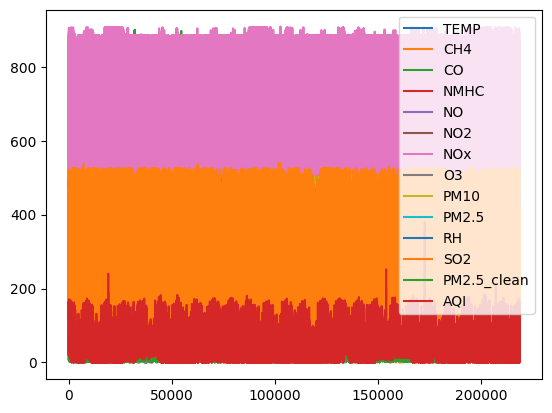

In [26]:
df.plot()
plt.show()

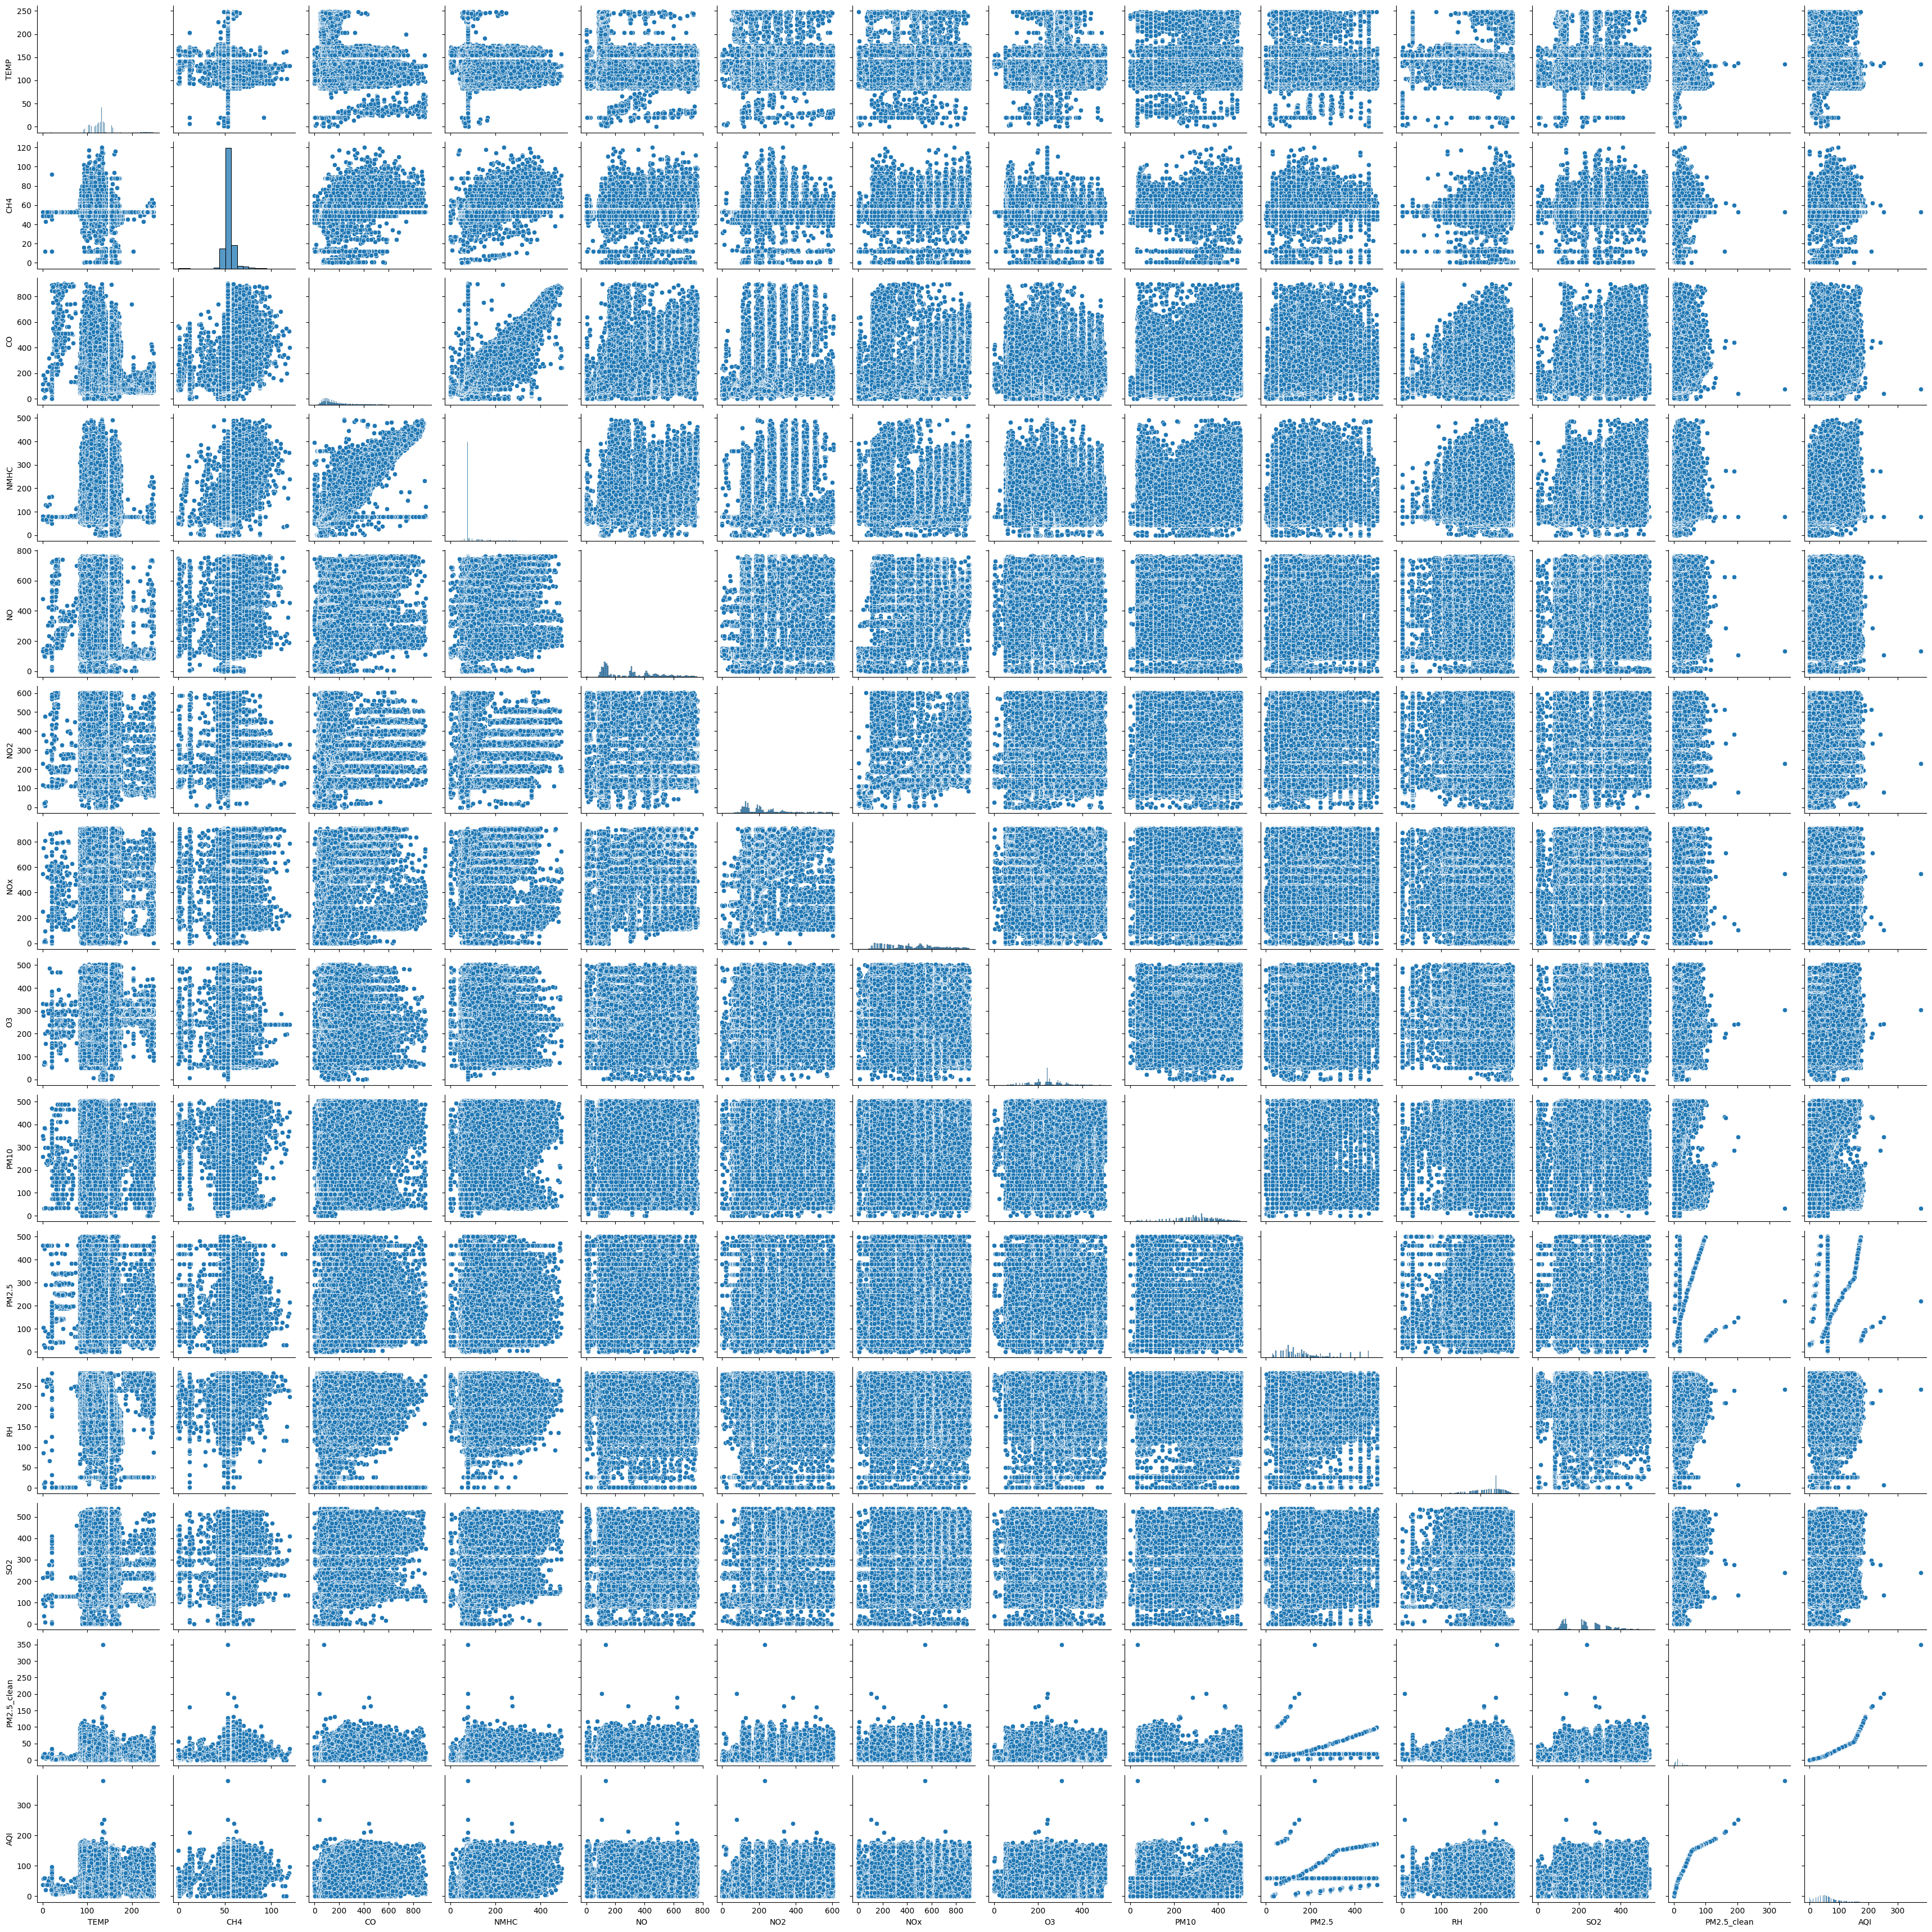

In [27]:
sns.pairplot(df)

# Pearson Correlation of Features

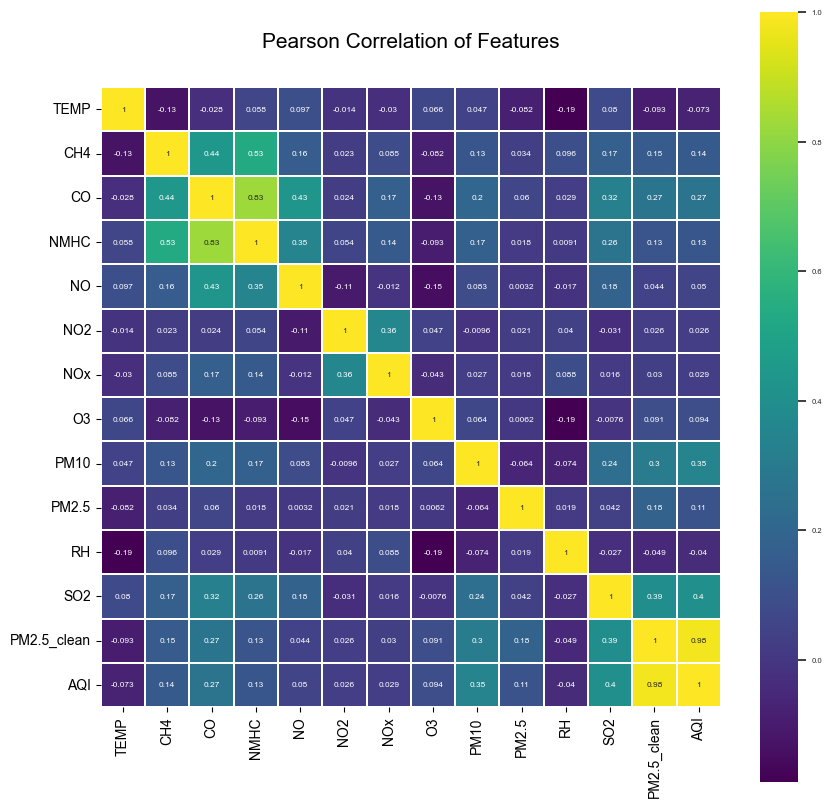

In [28]:
colormap = plt.cm.viridis
plt.figure(figsize=(10, 10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.5)
sns.heatmap(
    df.corr(),  # Fixed: Removed invalid parentheses
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=colormap,
    linecolor='white',
    annot=True
)
plt.show()  # Added to display the plot

In [29]:
df.columns

Index(['TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5',
       'RH', 'SO2', 'PM2.5_clean', 'AQI'],
      dtype='object')

In [30]:
df.shape

(217531, 14)

## Split the dataset into train and test sets

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, test_size=0.30, shuffle=False)


In [32]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Machine Learning Modeling

## 1. KNEIGHBORSREGRESSION

In [33]:
# 1. KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

## 2.LINEAR REGRESSION

In [34]:
# 2. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

##  3. Support Vector Regression (SVR)

In [35]:
# 3. Support Vector Regression (SVR)
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

# Deep Learning Models

In [36]:
# Deep Learning Models
# Reshape for LSTM/CNN
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

##  4. LSTM Model 

In [37]:
# 4. LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

Epoch 1/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 1601.9578 - val_loss: 129.6484
Epoch 2/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 50.4372 - val_loss: 3.7972
Epoch 3/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 1.7955 - val_loss: 1.1873
Epoch 4/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 1.3457 - val_loss: 0.6699
Epoch 5/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.7127 - val_loss: 0.6153
Epoch 6/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 1.6046 - val_loss: 0.5364
Epoch 7/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.6611 - val_loss: 0.4209
Epoch 8/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.5386 - val_loss: 0.5123
Epoch 9/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.5705 - val_loss: 0.4028
Epoch 10/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.5236 - val_loss: 0.3322
Epoch 11/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.4290 - val_loss: 0.3982
Epoch 12/20
3

##  5. CNN-LSTM Model 

In [38]:
# 5. CNN-LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(64))
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test_lstm).flatten()

Epoch 1/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 1632.0569 - val_loss: 232.6411
Epoch 2/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 109.4573 - val_loss: 16.1503
Epoch 3/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 9.9199 - val_loss: 6.0281
Epoch 4/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 4.4749 - val_loss: 3.1919
Epoch 5/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 3.0794 - val_loss: 2.4920
Epoch 6/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 2.3039 - val_loss: 1.8598
Epoch 7/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 1.9069 - val_loss: 1.7341
Epoch 8/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 1.5657 - val_loss: 1.5108
Epoch 9/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 1.4537 - val_loss: 1.4637
Epoch 10/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 1.2613 - val_loss: 1.0596
Epoch 11/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 1.1516 - val_loss: 1.0442
Epoch 12/20

#  Evaluations

In [39]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluation Results for {model_name}:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.2f}")
    

In [41]:
def evaluate_accuracy(y_true, y_pred):
    accuracy = np.mean(np.abs(y_true - y_pred) <= 10) * 100
    print(f"Accuracy (±10 AQI): {accuracy:.2f}%")


In [42]:
# Evaluate all models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_knn, "KNN Regressor")
evaluate_model(y_test, y_pred_svr, "SVR")
evaluate_model(y_test, y_pred_lstm, "LSTM")
evaluate_model(y_test, y_pred_cnn_lstm, "CNN-LSTM")


Evaluation Results for Linear Regression:
MAE: 4.71
RMSE: 7.12
R² Score: 0.95

Evaluation Results for KNN Regressor:
MAE: 6.75
RMSE: 10.08
R² Score: 0.90

Evaluation Results for SVR:
MAE: 2.74
RMSE: 6.76
R² Score: 0.96

Evaluation Results for LSTM:
MAE: 0.40
RMSE: 1.10
R² Score: 1.00

Evaluation Results for CNN-LSTM:
MAE: 0.78
RMSE: 1.59
R² Score: 1.00


#  Visualization


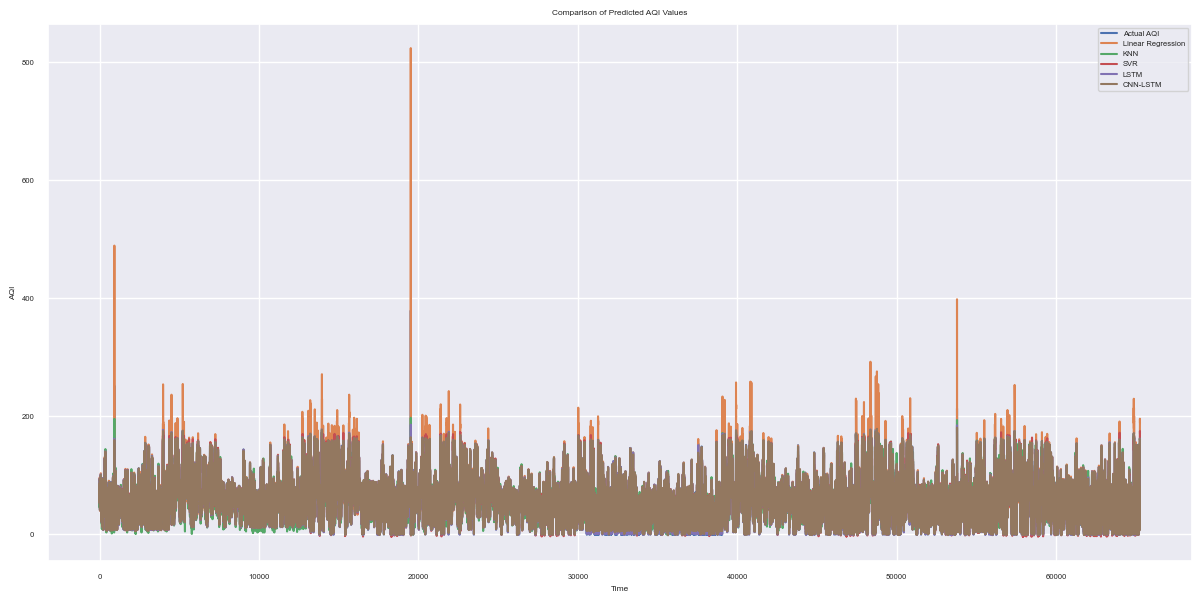

In [43]:
# Visualization of AQI predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual AQI')
plt.plot(y_pred_lr, label='Linear Regression')
plt.plot(y_pred_knn, label='KNN')
plt.plot(y_pred_svr, label='SVR')
plt.plot(y_pred_lstm, label='LSTM')
plt.plot(y_pred_cnn_lstm, label='CNN-LSTM')
plt.legend()
plt.title("Comparison of Predicted AQI Values")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

In [44]:
# AQI Categories visualization
aqi_categories = {
    'Good': (0, 50),
    'Moderate': (51, 100),
    'Unhealthy for Sensitive Groups': (101, 150),
    'Unhealthy': (151, 200),
    'Very Unhealthy': (201, 300),
    'Hazardous': (301, 500)
}


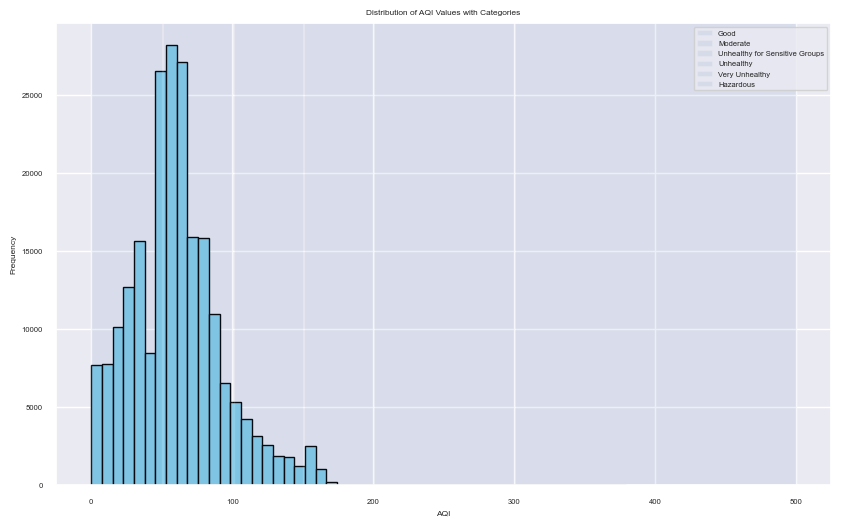

In [45]:
# Plot AQI distribution
plt.figure(figsize=(10, 6))
plt.hist(df['AQI'], bins=50, color='skyblue', edgecolor='black')
for category, (low, high) in aqi_categories.items():
    plt.axvspan(low, high, alpha=0.1, label=category)
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.title('Distribution of AQI Values with Categories')
plt.legend()
plt.show()

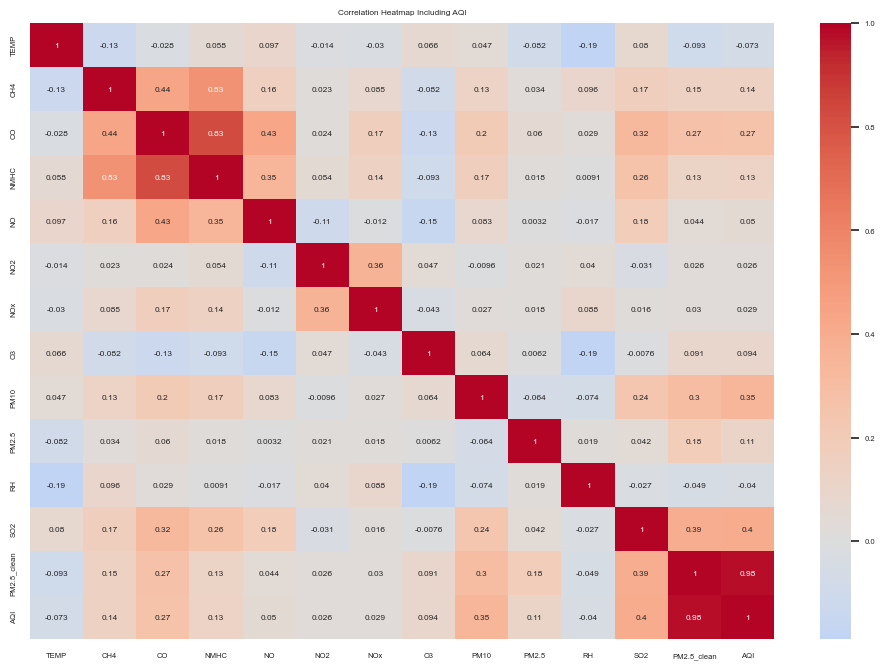

In [46]:
# Correlation heatmap with AQI
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap Including AQI')
plt.show()

# The End!